In [21]:
import json
import random as r
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFile
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from random import shuffle

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

def print_image_data(js):
    print("Url: {}".format(js['content']))
          
    print('Annotations: ')
    for ann in js['annotation']:
        print("  {}".format(ann['points']))
#     Uncomment for additional information
#     print("Extras: {}").format(js['extras'])
#     print('Metadata: ')
#     for k, v in js['metadata'].items():
#           print('  {} - {}').format(k, v)   

def is_scaled(point):
    return (0 <= point['x'] <= 1 or
            0 <= point['y'] <= 1)

def draw_image(image_data, show_faces=False):
    url = image_data['content']
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    size = img.size
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    if show_faces:
        width, height = size
        for ann in image_data['annotation']:
            bbox = ann['points']
            point1, point2 = bbox
            if is_scaled(point1):
                unscale_point(point1, width, height)

            if is_scaled(point2):
                unscale_point(point2, width, height)            
            left, upper, right, lower = point1['x'], point1['y'], point2['x'], point2['y']
            rect = patches.Rectangle((left,upper), right-left , lower-upper, linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
    plt.title('Image {}'.format(size))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def read_json_images(file_path):
    with open(annotation_path) as file:
        return [json.loads(item) for item in file.readlines()]
        
def train_test_split(iterable, test_size=0.25, shuffle_data=True):
    length = len(iterable)
    n_test = int(length*test_size)
    
    if shuffle_data:
        shuffle(iterable)
    
    train = iterable[:-n_test]
    test = iterable[-n_test:]
    
    return train, test

annotation_path = './face_detection.json'
json_images = read_json_images(annotation_path)

n_images = len(json_images)
print('Number of images: {}'.format(n_images))

train, test = train_test_split(json_images)
print('Train size: {}'.format(len(train)))
print('Test size: {}'.format(len(test)))

Number of images: 409
Train size: 307
Test size: 102


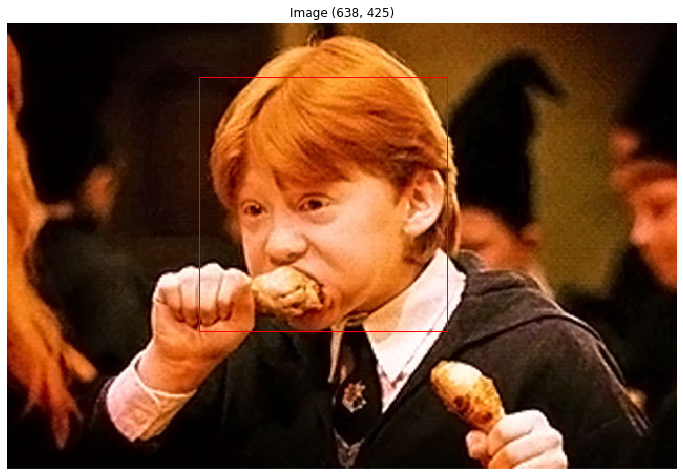

In [37]:
random_image = json_images[r.randint(0, n_images-1)]
draw_image(random_image, True)

In [31]:
import re
import uuid


def unscale_point(point, w, h):
    point['x'] *= w
    point['y'] *= h

def fill_transparency(image):
    background = Image.new(image.mode[:-1], image.size, (255, 255, 255))
    background.paste(image, image.split()[-1])
    return background

def label_image(img, img_name, img_annotation, xml_file_path):
    with open('object_label_template.xml') as file:
        labeled_object_template = ''.join(file.readlines())
        
    width, height = img.size
    xml_template = labeled_object_template.format(
        img_name=img_name,
        img_width=width,
        img_height=height,
        left='{left}',
        upper='{upper}',
        right='{right}',
        lower='{lower}'
    )
    bnd_box_pattern = re.compile(r'\s*<bndbox>\s*.*\s*\s*.*\s*\s*.*\s*\s*.*\s*<\/bndbox>')
    match = re.search(bnd_box_pattern, labeled_object_template)
    if not match:
        raise 'Invalid match pattern'

    coords_template = match.group(0)
    
    bndbox_strs = []
    for ann in img_annotation:
        bbox = ann['points']
        point1, point2 = bbox
        if is_scaled(point1):
            unscale_point(point1, width, height)

        if is_scaled(point2):
            unscale_point(point2, width, height)    

        left, upper, right, lower = point1['x'], point1['y'], point2['x'], point2['y']
        bndbox_strs.append(coords_template.format(
            left=left,
            upper=upper,
            right=right,
            lower=lower
        ))
        
    img_label = re.sub(bnd_box_pattern, '\n'.join(bndbox_strs), xml_template)
    with open(xml_file_path, 'w') as file:
        file.writelines(img_label)

def save_images(images_data, save_folder_path, ext='jpg'):
    for i in range(len(images_data)):
        img_data = json_images[i]
        
        url = img_data['content']
        response = requests.get(url)
        try:
            img = Image.open(BytesIO(response.content))
        except Exception as e:
            print('Could not save image {}. {}'.format(url, e))
            continue
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        img_name = str(uuid.uuid4())
        img.save(save_folder_path + '/{}.{}'.format(img_name, ext), quality=90)

        label_image(img,
                    img_name,
                    img_data['annotation'], 
                    save_folder_path+'/{}.xml'.format(img_name)
                   )

In [33]:
import threading
import os
import shutil
import threading
import time


def _clean_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete {}. Reason: {}'.format(file_path, e))

train_folder = './images/train'
test_folder = './images/test'
clean_data_folders = True

if clean_data_folders:
    _clean_folder(train_folder)
    _clean_folder(test_folder)

print('Started downloading train data.')
tick = time.time()
save_images(train, train_folder)
tock = time.time()
print('Train data loaded. ({}s)'.format(round(tock - tick, 1)))

print('Started downloading test data')
tick = time.time()
save_images(test, test_folder)
tock = time.time()
print('Test data loaded. ({}s)'.format(round(tock - tick, 1)))

Started downloading train data.
Could not save image http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/aaa5a997-b248-4724-9002-b29117725102___0rCMbYS7vkSINlu61.jpg. cannot identify image file <_io.BytesIO object at 0x000001EB8101BB48>
Train data loaded. (349.8s)
Started downloading test data
Test data loaded. (105.7s)
